# CARE Prediction
Please run the `1_CARETraining.ipynb` notebook before going through this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

import torch
from tifffile import imread

from ppn2v.unet import UNet


from ppn2v.pn2v.utils import PSNR
from ppn2v.pn2v import utils
from ppn2v.pn2v import prediction

from ppn2v.pn2v import histNoiseModel

# See if we can use a GPU

vice=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse skull nuclei/'

# Load the test data
dataTest=imread(path+"example2_digital_offset300.tif")[:,:,:256] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]

### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_CareTraining.ipynb```.

In [3]:
dataName = 'mouseskullnuclei' # Use the same name as used in 1_CareTraining.ipynb. This is a part of model name created in 1_CareTraining.ipynb 
nameModel=dataName+'_care'

In [4]:
# Load the network, created in the '1_CareTraining.ipynb' notebook
net=torch.load(path+"/last_"+nameModel+".net")

/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


### Evaluation

image: 0
PSNR input 28.02423798473431
PSNR CARE 36.41979804604876
-----------------------------------
image: 1
PSNR input 28.065531602490644
PSNR CARE 36.57997122992804
-----------------------------------
image: 2
PSNR input 28.035021421910734
PSNR CARE 36.6002701162608
-----------------------------------
image: 3
PSNR input 28.087744381628678
PSNR CARE 36.64091776171909
-----------------------------------
image: 4
PSNR input 28.061745249613562
PSNR CARE 36.48632122275205
-----------------------------------
image: 5
PSNR input 28.1086316653067
PSNR CARE 36.63221250374265
-----------------------------------
image: 6
PSNR input 28.11584919615069
PSNR CARE 36.71284475519696
-----------------------------------
image: 7
PSNR input 28.078571033189487
PSNR CARE 36.646435323241505
-----------------------------------
image: 8
PSNR input 28.074885947043384
PSNR CARE 36.70046223667007
-----------------------------------
image: 9
PSNR input 28.07332624770129
PSNR CARE 36.6702081385327
------------

image: 84
PSNR input 28.147747433378754
PSNR CARE 36.8094600724733
-----------------------------------
image: 85
PSNR input 28.05941189116683
PSNR CARE 36.752273694879264
-----------------------------------
image: 86
PSNR input 28.127643551664228
PSNR CARE 36.84964430689731
-----------------------------------
image: 87
PSNR input 28.08121949230629
PSNR CARE 36.78742566231109
-----------------------------------
image: 88
PSNR input 28.059232560915703
PSNR CARE 36.75064587971147
-----------------------------------
image: 89
PSNR input 28.19382713905987
PSNR CARE 36.84877880423254
-----------------------------------
image: 90
PSNR input 28.130898215242123
PSNR CARE 36.82403484448526
-----------------------------------
image: 91
PSNR input 28.126900638380384
PSNR CARE 36.932621651448024
-----------------------------------
image: 92
PSNR input 28.10039320763121
PSNR CARE 36.85022290006761
-----------------------------------
image: 93
PSNR input 28.0978473480966
PSNR CARE 36.68940684657241
-

image: 168
PSNR input 28.13743200332155
PSNR CARE 36.73912782519665
-----------------------------------
image: 169
PSNR input 28.107202050060014
PSNR CARE 36.67825675324786
-----------------------------------
image: 170
PSNR input 28.129349900229915
PSNR CARE 36.77477489759032
-----------------------------------
image: 171
PSNR input 28.095528850713556
PSNR CARE 36.710200068793824
-----------------------------------
image: 172
PSNR input 28.09546502904469
PSNR CARE 36.695425910487735
-----------------------------------
image: 173
PSNR input 28.10880860720517
PSNR CARE 36.578200806949816
-----------------------------------
image: 174
PSNR input 28.143358162105095
PSNR CARE 36.80207158536439
-----------------------------------
image: 175
PSNR input 28.13986913733029
PSNR CARE 36.723442753477855
-----------------------------------
image: 176
PSNR input 28.096411596990297
PSNR CARE 36.62809225949039
-----------------------------------
image: 177
PSNR input 28.083653949170152
PSNR CARE 36.7

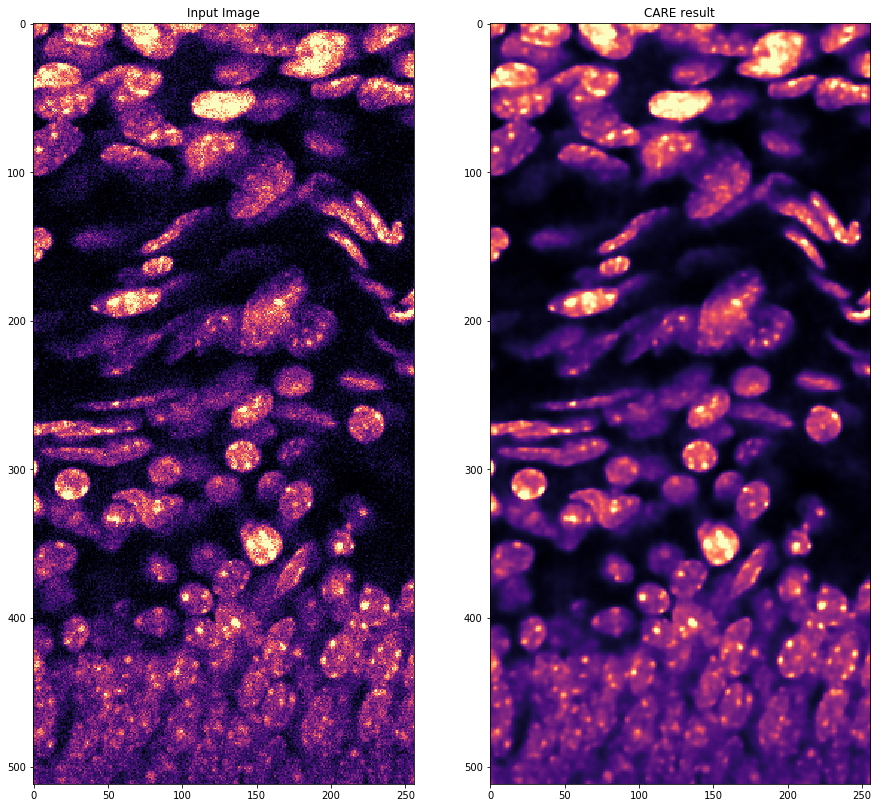

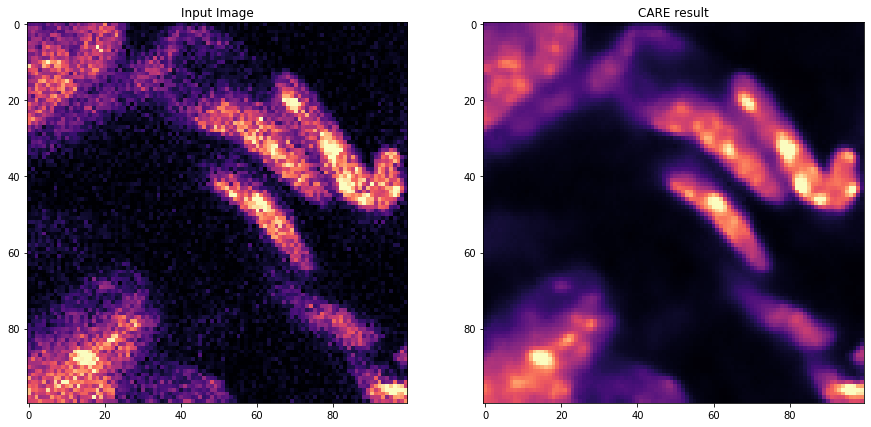

Avg PSNR CARE: 36.69365665860799 +-(2SEM) 0.010136084613377833


In [5]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=PSNR(gt, careResult,rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input", PSNR(gt, im, rangePSNR))
    print ("PSNR CARE", carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )